In [15]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\College\III_year_II_part\WDSS
d:\College\III_year_II_part\WDSS


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

import tqdm

from typing import List, Tuple, Dict

from config import device, Settings
from commons import initialize

In [17]:
settings = Settings("config/config.json", "WDSSV5")
initialize(settings=settings)

Job: myassnigga, Model: WDSSV5, Device: cuda
Model path: out\myassnigga-WDSSV5\model
Log path: out\myassnigga-WDSSV5\logs


In [18]:
from network.dataset import *

# Load the dataset
dataset = WDSSDatasetCompressed(settings.train_dir, 119)

# Load the raw frames
raw_frames = dataset._get_raw_frames(60, True)

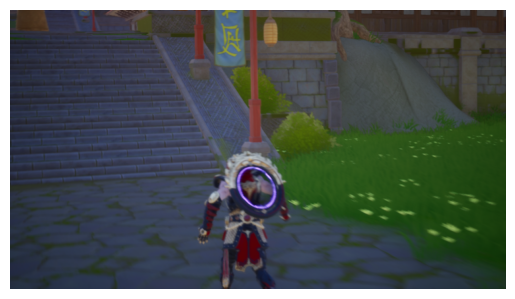

In [19]:
hr = raw_frames[RawFrameGroup.HR]
ImageUtils.display_image(hr)

In [20]:
hr_images = []
for i in tqdm.tqdm(range(len(dataset))):
    raw_frames = dataset._get_raw_frames(i, True)
    image = raw_frames[RawFrameGroup.HR].cpu().numpy().transpose(1, 2, 0)
    hr_images.append(image)

100%|██████████| 476/476 [00:50<00:00,  9.43it/s]


100%|██████████| 476/476 [02:34<00:00,  3.08it/s]
d:\College\III_year_II_part\WDSS\.conda\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\College\III_year_II_part\WDSS\.conda\Lib\site-packages\matplotlib\axes\_axes.py:7096: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


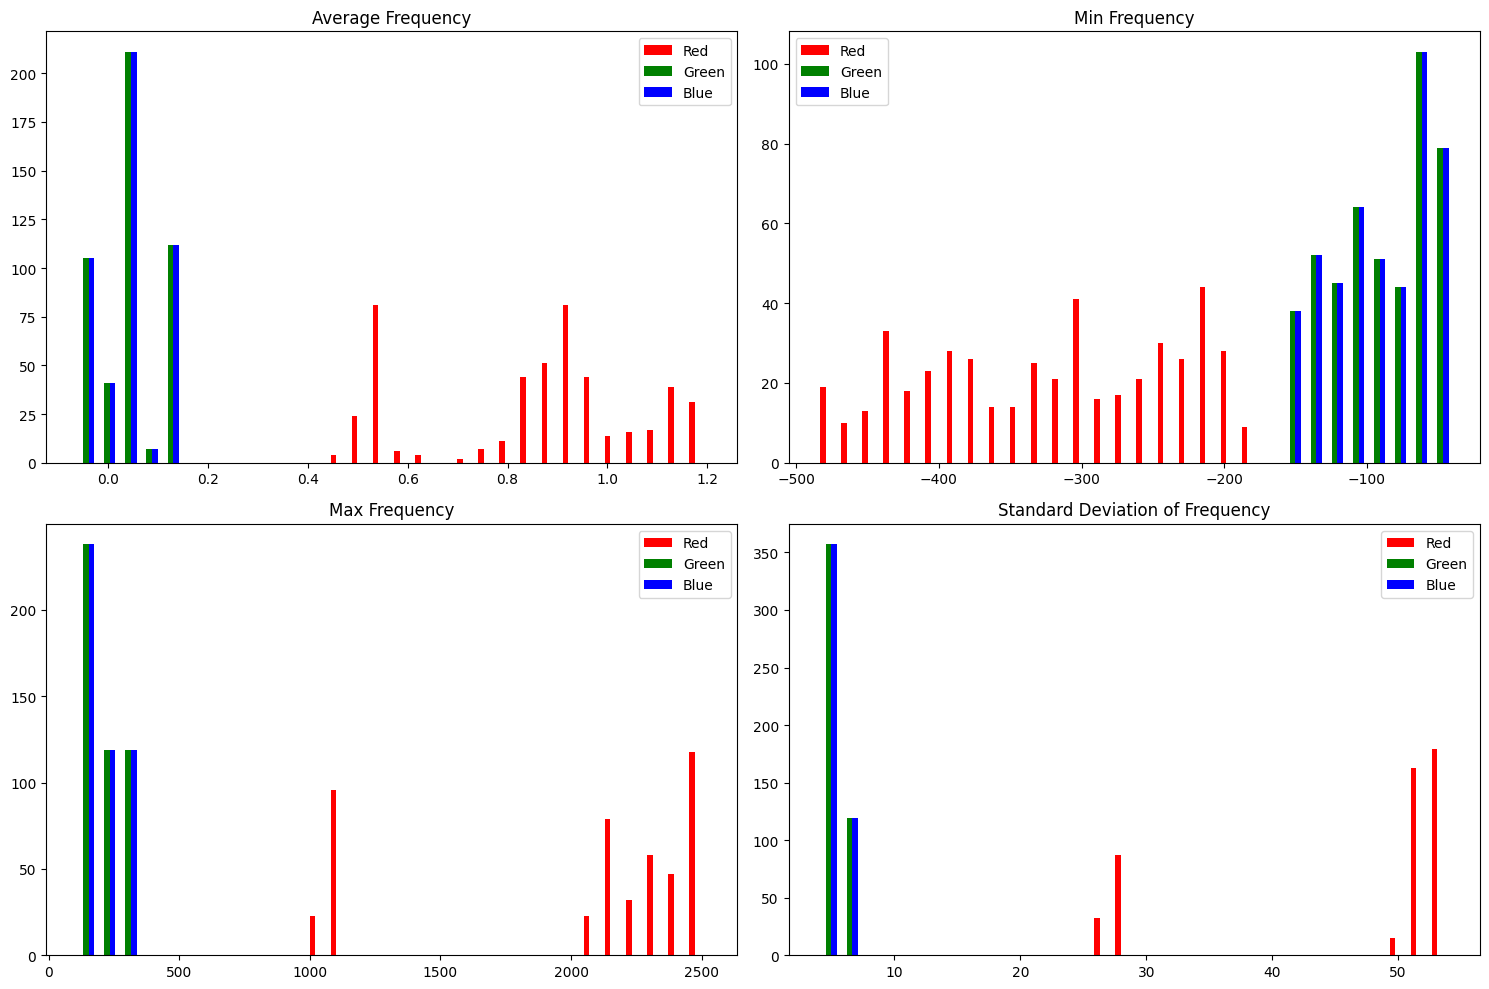

In [21]:
# Calculate the average, min, max, and standard deviation of frequencies for each image's RGB channels
avg_freqs = []
min_freqs = []
max_freqs = []
std_freqs = []

for image in tqdm.tqdm(hr_images):
    #calculate fouier transform of the image
    image = np.fft.fft2(image)
    avg_freqs.append(np.mean(image, axis=(0, 1)))
    min_freqs.append(np.min(image, axis=(0, 1)))
    max_freqs.append(np.max(image, axis=(0, 1)))
    std_freqs.append(np.std(image, axis=(0, 1)))

# Convert lists to numpy arrays for easier manipulation
avg_freqs = np.array(avg_freqs)
min_freqs = np.array(min_freqs)
max_freqs = np.array(max_freqs)
std_freqs = np.array(std_freqs)

# Plot histograms
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].hist(avg_freqs, bins=30, color=['r', 'g', 'b'], label=['Red', 'Green', 'Blue'])
axs[0, 0].set_title('Average Frequency')
axs[0, 0].legend()

axs[0, 1].hist(min_freqs, bins=30, color=['r', 'g', 'b'], label=['Red', 'Green', 'Blue'])
axs[0, 1].set_title('Min Frequency')
axs[0, 1].legend()

axs[1, 0].hist(max_freqs, bins=30, color=['r', 'g', 'b'], label=['Red', 'Green', 'Blue'])
axs[1, 0].set_title('Max Frequency')
axs[1, 0].legend()

axs[1, 1].hist(std_freqs, bins=30, color=['r', 'g', 'b'], label=['Red', 'Green', 'Blue'])
axs[1, 1].set_title('Standard Deviation of Frequency')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [14]:
raw_frames = dataset._get_raw_frames(3, True)
gbuffers = raw_frames[RawFrameGroup.HR_GB]

KeyError: <RawFrameGroup.HR_GB: 'HighResGBuffer'>

In [13]:
def visualize_gbuffer_channel(gbuffers, channel_type, title):
    # Convert the tensor to a numpy array
    channel_np = gbuffers[channel_type].cpu().numpy()

    # Plot the data without changing the color
    plt.figure(figsize=(10, 8))
    plt.imshow(channel_np[0], cmap=None)
    plt.colorbar(label=channel_type.name)
    plt.title(title)
    plt.show()


channel = [GB_Type.ROUGHNESS, GB_Type.DEPTH, GB_Type.METALLIC, GB_Type.SPECULAR]
# Example usage:
for channel_type in channel:
    visualize_gbuffer_channel(gbuffers, channel_type, f'{channel_type.name} Visualization')


NameError: name 'gbuffers' is not defined

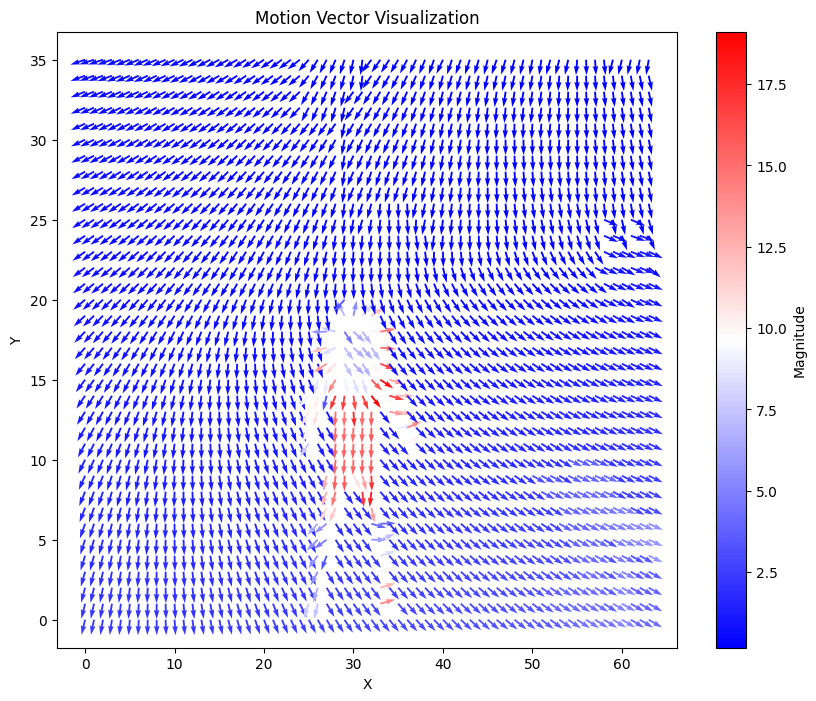

In [85]:

def visualize_motion_vector(motion_vector, title):
    # Convert the tensor to a numpy array
    motion_vector = ImageUtils.upsample(motion_vector.unsqueeze(0), 0.05).squeeze(0)
    motion_vector_np = motion_vector.cpu().numpy()

    # Extract the horizontal and vertical components of the motion vector
    u = motion_vector_np[0]
    v = motion_vector_np[1]

    # Flip the motion vector image horizontally
    u = np.flipud(u)
    v = np.flipud(v)

    # Create a grid of coordinates
    x = np.arange(0, u.shape[1])
    y = np.arange(0, u.shape[0])
    x, y = np.meshgrid(x, y)

    # Normalize the motion vectors to keep the arrow length equal
    magnitude = np.sqrt(u**2 + v**2)
    u_normalized = u / (magnitude + 1e-5)
    v_normalized = v / (magnitude + 1e-5)

    # Plot the motion vectors using quiver with thicker, more continuous lines
    plt.figure(figsize=(10, 8))
    quiver = plt.quiver(
        x,
        y,
        u_normalized,
        v_normalized,
        magnitude,
        scale=40,  # Lower scale for more continuous arrows
        width=0.003,  # Increase width for thicker lines
        cmap=plt.cm.bwr,
    )
    plt.colorbar(quiver, label='Magnitude')
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Example usage:
motion_vector = gbuffers[GB_Type.MOTION_VECTOR]
visualize_motion_vector(motion_vector, 'Motion Vector Visualization')



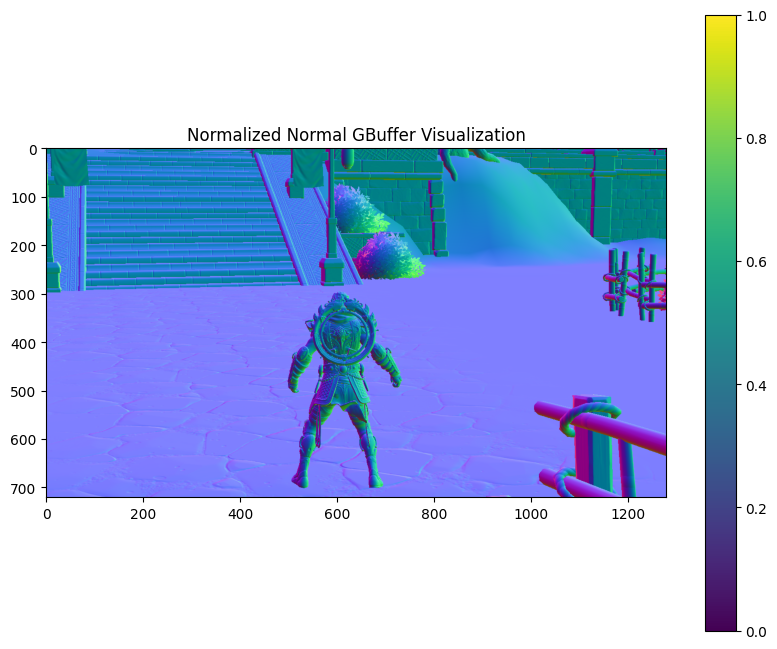

In [94]:
def visualize_normal_gbuffer(normal_gbuffer, title):
    # Convert the tensor to a numpy array
    normal_np = normal_gbuffer.cpu().numpy().transpose(1, 2, 0)
    
    # Normalize the normal map to the range [0, 1]
    normal_np = (normal_np - normal_np.min()) / (normal_np.max() - normal_np.min())

    # Plot the normal map
    plt.figure(figsize=(10, 8))
    plt.imshow(normal_np)
    plt.colorbar()
    plt.title(title)
    plt.show()

# Example usage:
normal_gbuffer = gbuffers[GB_Type.NORMAL]
visualize_normal_gbuffer(normal_gbuffer, 'Normalized Normal GBuffer Visualization')
